In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
conn = psycopg2.connect(host = 'localhost', database = 'nytpopular')
with conn.cursor() as cursor:
    cursor.execute('''SELECT tweets.id, tweets.retweet_count, tweets.reply_count, tweets.like_count, tweets.date, articles.url FROM tweets
                        RIGHT JOIN articles ON tweets.id = articles.id;''')
    table = cursor.fetchall()
conn.close()

In [3]:
table = list(zip(*table))
id_ = pd.Series(table[0], name = 'id', dtype = np.int64)
retweet_count = pd.Series(table[1], name = 'retweet_count', dtype = np.int64)
reply_count = pd.Series(table[2], name = 'reply_count', dtype = np.int64)
like_count = pd.Series(table[3], name = 'like_count', dtype = np.int64)
date = pd.Series(table[4], name = 'date', dtype = 'datetime64[ns]')
url = pd.Series(table[5], name = 'url')

In [4]:
tweetData = pd.DataFrame({series.name: series for series in [id_, retweet_count, reply_count, like_count, date, url]})

In [5]:
tweetData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9124 entries, 0 to 9123
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             9124 non-null   int64 
 1   retweet_count  9124 non-null   int64 
 2   reply_count    9124 non-null   int64 
 3   like_count     9124 non-null   int64 
 4   date           9124 non-null   object
 5   url            9124 non-null   object
dtypes: int64(4), object(2)
memory usage: 427.8+ KB


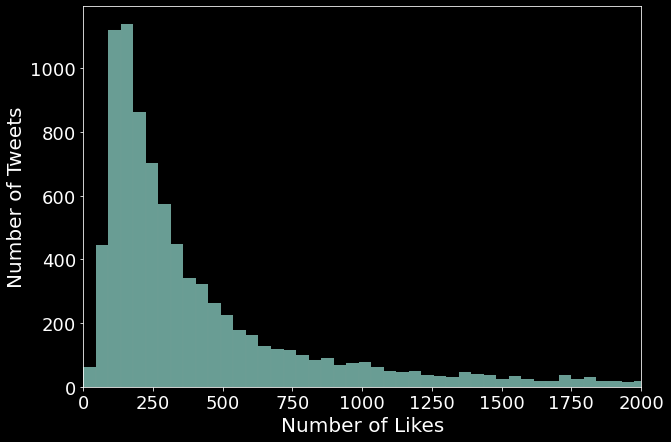

In [92]:
fig, ax = plt.subplots(figsize = (10,7))
sns.histplot(x = 'like_count', data = tweetData, ax = ax)
ax.set_xlim(0,2000)
ax.set_xlabel('Number of Likes', fontsize = 20)
ax.set_ylabel('Number of Tweets', fontsize = 20)
ax.tick_params(axis="y", labelsize=18)
ax.tick_params(axis="x", labelsize=18)

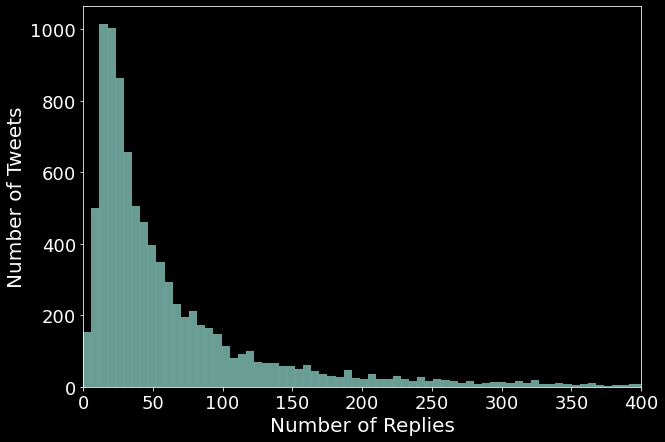

In [93]:
fig, ax = plt.subplots(figsize = (10,7))
sns.histplot(x = 'reply_count', data = tweetData, ax = ax)
ax.set_xlim(0,400)
ax.set_xlabel('Number of Replies', fontsize = 20)
ax.set_ylabel('Number of Tweets', fontsize = 20)
ax.tick_params(axis="y", labelsize=18)
ax.tick_params(axis="x", labelsize=18)

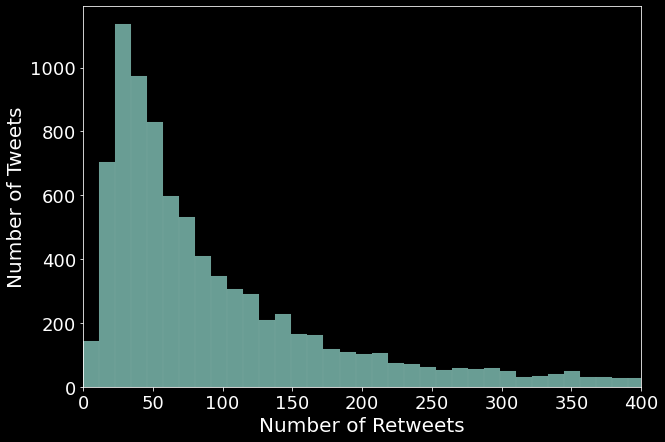

In [94]:
fig, ax = plt.subplots(figsize = (10,7))
sns.histplot(x = 'retweet_count', data = tweetData, ax = ax)
ax.set_xlim(0,400)
ax.set_xlabel('Number of Retweets', fontsize = 20)
ax.set_ylabel('Number of Tweets', fontsize = 20)
ax.tick_params(axis="y", labelsize=18)
ax.tick_params(axis="x", labelsize=18)

In [9]:
tweetData.describe()

,id,retweet_count,reply_count,like_count
count,9.124000e+03,9124.000000,9124.000000,9124.000000
mean,1.496292e+18,204.646646,92.040443,833.995726
std,1.085756e+16,652.894090,240.392747,2682.984105
min,1.477067e+18,0.000000,0.000000,0.000000
25%,1.487153e+18,38.000000,21.000000,159.000000
50%,1.496243e+18,72.000000,39.000000,286.000000
75%,1.505659e+18,158.000000,82.000000,628.000000
max,1.515445e+18,20463.000000,8473.000000,116847.000000


In [10]:
tweetData['articleDate'] = pd.to_datetime(tweetData['url'].str.extract(r'/(20\d{2}/\d{2}/\d{2})/')[0])

In [11]:
urlSection = tweetData['url'].str.extract(r'/20\d{2}[\d/]*/(.*)/.*$|.com/(recipes)/|.com/(wirecutter)/|.com/(video/.*)/\d*/.*$|.com/(article)/')

In [12]:
tweetData['url_section'] = urlSection[0].fillna('') + urlSection[1].fillna('') + urlSection[2].fillna('') + urlSection[3].fillna('') + urlSection[4].fillna('')

In [96]:
tweetData['url_section'].value_counts()

world                  1342
world/europe            980
us                      888
us/politics             675
nyregion                511
                       ... 
11                        1
t-magazine                1
sports/horse-racing       1
automobiles               1
sports/cricket            1
Name: url_section, Length: 66, dtype: int64

In [14]:
agg_funcs = ['mean', 'median']
section_summary = tweetData.groupby('url_section').agg({'id': 'count', 'like_count': agg_funcs, 'retweet_count': agg_funcs, 'reply_count': agg_funcs})

In [15]:
section_summary[section_summary[('id', 'count')] > 10].sort_values(('like_count', 'median'), ascending = False)

id   like_count        retweet_count        reply_count  \
                   count         mean median          mean median        mean   
url_section                                                                     
video/world/europe    22   727.909091  611.0    237.818182  179.5   71.954545   
sports/soccer         29  2730.724138  551.0    634.655172   99.0  134.724138   
world               1341  1494.726324  515.0    383.970917  151.0  124.938106   
recipes               88   638.284091  475.5     74.943182   53.0   26.659091   
obituaries            16   841.750000  473.5    170.437500   89.0   51.375000   
...                  ...          ...    ...           ...    ...         ...   
your-money            12   176.500000  119.5     47.750000   29.0   26.000000   
podcasts              21   143.047619   97.0     33.047619   20.0   17.190476   
espanol               91   111.252747   91.0     29.351648   24.0   21.824176   
headway               26    86.192308   47.5     24.384615    8.0    5.538462   
special-series        11    37.909091   12.0      9.909091    5.0    8.363636   

                           
                   median  
url_section                
video/world/europe   61.5  
sports/soccer        64.0  
world                69.0  
recipes              23.5  
obituaries           33.5  
...                   ...  
your-money           18.0  
podcasts             12.0  
espanol              14.0  
headway               3.0  
special-series        3.0  

[64 rows x 7 columns]

In [97]:
section_summary.to_clipboard()

In [16]:
conn = psycopg2.connect(host = 'localhost', database = 'nytpopular')
with conn.cursor() as cursor:
    cursor.execute('''SELECT tweets.id, metadata.news_desk, metadata.section, metadata.subsection, metadata.keywords FROM tweets
                    LEFT JOIN id_map ON tweets.id = id_map.tweet_id
                    LEFT JOIN metadata on id_map.uri_id = metadata.id;''')
    table = cursor.fetchall()
conn.close()

table = list(zip(*table))
id_ = pd.Series(table[0], name = 'id', dtype = np.int64)
news_desk = pd.Series(table[1], name = 'news_desk')
section = pd.Series(table[2], name = 'section')
subsection = pd.Series(table[3], name = 'subsection')
keywords = pd.Series(table[4], name = 'keywords')
sectionMetadata = pd.DataFrame({series.name: series for series in [id_, news_desk, section, subsection, keywords]})

In [17]:
tweetData = tweetData.merge(sectionMetadata, how = 'left', left_on = 'id', right_on = 'id')

In [18]:
tweetData.loc[tweetData['url_section'].str.contains('world/europe'), 'url_section'] = 'world/europe'
tweetData.loc[tweetData['url_section'].str.contains('us/politics|us/elections'), 'url_section'] = 'us/politics'
tweetData.loc[tweetData['url_section'].str.contains('wirecutter'), 'url_section'] = 'wirecutter'
tweetData.loc[tweetData['url_section'] == 'video/world', 'url_section'] = 'world'
tweetData.loc[tweetData['url_section'].str.contains('well'), 'url_section'] = 'wellness'
tweetData.loc[tweetData['url_section'].str.contains('opinion'), 'url_section'] = 'opinion'
tweetData.loc[tweetData['url_section'].str.contains('basketball'), 'url_section'] = 'sports/basketball'
tweetData.loc[tweetData['url_section'].str.contains('books'), 'url_section'] = 'books'
tweetData.loc[tweetData['url_section'].str.contains('podcasts'), 'url_section'] = 'podcasts'
tweetData.loc[tweetData['url_section'].str.contains('science'), 'url_section'] = 'science'
tweetData.loc[tweetData['url_section'].str.contains('dining'), 'url_section'] = 'dining'
tweetData.loc[tweetData['url_section'].str.contains('fashion|style'), 'url_section'] = 'style&fashion'
tweetData.loc[tweetData['url_section'].str.contains('technology'), 'url_section'] = 'technology'
# tweetData['url_section'].value_counts().to_clipboard()

In [19]:
tweetData['log_likes'] = np.log(tweetData['like_count'] + 1)/np.log(10)

In [20]:
filtered_tweetData = tweetData[tweetData['url_section'].isin(section_summary[section_summary[('id', 'count')] > 10].index)].copy()
filtered_tweetData['like_bins'] = pd.cut(filtered_tweetData['like_count'], [0,100,200,500,1000,200000])

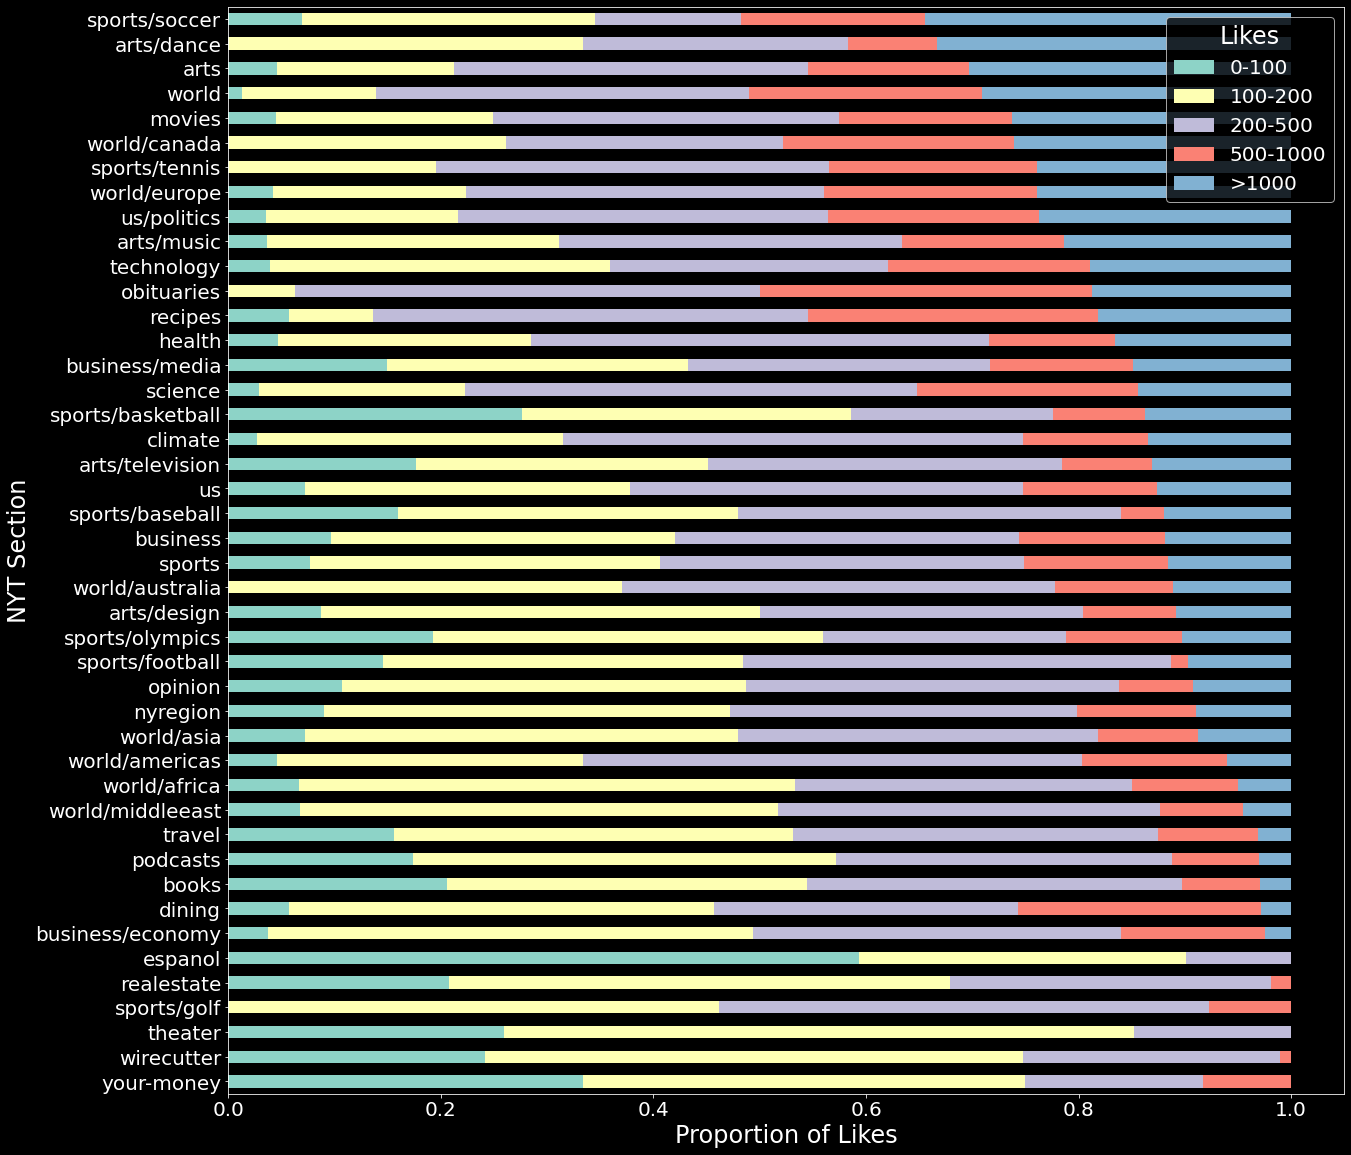

In [21]:
likeBinsGroup = filtered_tweetData.groupby(['url_section', 'like_bins']).size().unstack()
likeBinsProp = likeBinsGroup.div(likeBinsGroup.sum(axis = 1), axis = 0)
likeBinsProp = likeBinsProp.sort_values(likeBinsGroup.columns[-1], ascending = True)
likeBinsProp = likeBinsProp[~likeBinsProp.index.str.contains('energy-environment|magazine|article|briefing|upshot|headway|dealbook|special')]
fig = plt.figure(figsize = (20, 20))
ax = fig.subplots(1)
likeBinsProp.plot(kind = 'barh', stacked = True, ax = ax)
ax.set_xlabel('Proportion of Likes', fontsize = 24)
ax.set_ylabel('NYT Section', fontsize = 24)
ax.tick_params(axis="y", labelsize=20)
ax.tick_params(axis="x", labelsize=20)
ax.legend(['0-100', '100-200', '200-500', '500-1000', '>1000'], title = 'Likes', title_fontsize = 24, fontsize = 20)

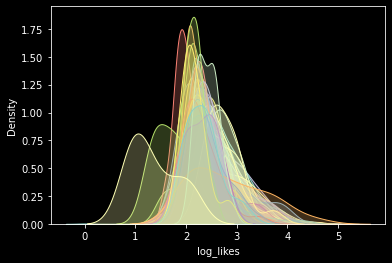

In [22]:
fig, ax = plt.subplots()
for sec in filtered_tweetData['url_section'].unique():
    sns.kdeplot(filtered_tweetData['log_likes'].loc[filtered_tweetData['url_section'] == sec], shade = True, label = sec, ax = ax)
#ax.set_xlim(0, 700)
#ax.set_ylim(0, 0.015)

In [23]:
import re

tweetDataWithTopics = tweetData.copy()

topics = {
            'Ukraine': 'Ukraine',
            'Covid': 'Coronavirus',
            'Trump': 'Trump',
            'Biden': 'Biden',
            'Olympics': 'Olympic',
            'Jan 6': 'Storming of the US Capitol',
            'Real Estate & Housing': 'Real Estate|Housing',
            'Ketanji Brown Jackson': 'Ketanji',
            'Climate': 'Greenhouse|Climate|Warming',
            'Murder': 'Murder',
            'American Football': '^(?=.*Football)(?!.*Soccer)',
            'China (not Olympics)': '^(?=.*China)(?!.*Olympic)',
            'Science & Technology': 'Science|Technology|Space',
            'French Election': '(?=.*France|.*French)(?=.*Election)',
            'Inflation': 'Inflation'
}

for key, item in topics.items():
    tweetDataWithTopics[key] = np.nan
    tweetDataWithTopics.loc[tweetDataWithTopics['keywords'].str.contains(item, na = False, flags = re.IGNORECASE), key] = key

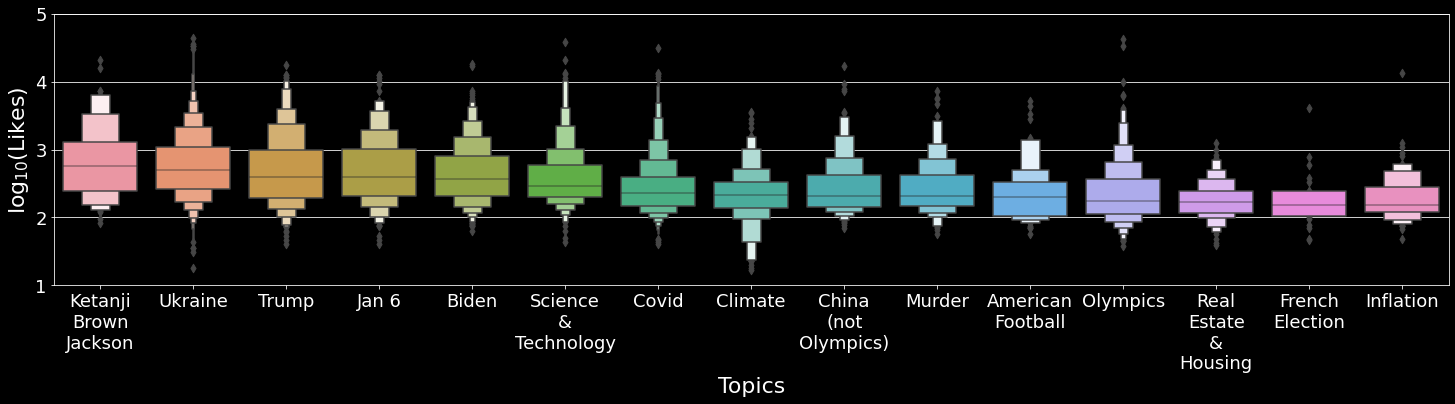

In [77]:
from matplotlib.ticker import MultipleLocator
import textwrap

# tweetDataWithTopics[~tweetDataWithTopics['Cryptocurrency'].isnull()]['keywords']
tweetDataMelted = tweetDataWithTopics.melt(id_vars = 'log_likes', value_vars=topics.keys(), value_name = 'topic').dropna()
order = tweetDataMelted.groupby('topic').agg('median').sort_values('log_likes', ascending = False).index
fig, ax = plt.subplots(figsize = (25, 5))
ax.grid(zorder = 0)
ax.yaxis.set_major_locator(MultipleLocator(1))
boxen = sns.boxenplot(x = 'topic', y = 'log_likes', data = tweetDataMelted, ax = ax, order = order)
ax.set_xticklabels([textwrap.fill(lab, 6, break_long_words = False) for lab in order])
plt.setp(boxen.collections, zorder = 10);
plt.setp(boxen.lines, zorder=11);
ax.set_ylim(1,5)
ax.set_xlabel('Topics', fontsize = 22)
ax.set_ylabel(r'$\log_{10}({\rm Likes})$', fontsize = 22)
ax.tick_params(axis="y", labelsize=18)
ax.tick_params(axis="x", labelsize=18)
#ax.set_ylim(0,5000)

In [68]:
tweetData['date'] = pd.to_datetime(tweetData['date'], utc = True)

In [69]:
from scipy.stats import bootstrap

hour = []
low = []
high = []
med = []
#tweetData['date'].dt.tz_convert('US/Eastern').dt.hour
for name, group in tweetData.groupby(tweetData['date'].dt.hour):
    hour.append(name)
    bootci = bootstrap((group['like_count'].to_numpy(), ), np.median, method = 'percentile').confidence_interval
    low.append(bootci.low)
    high.append(bootci.high)
    med.append(np.median(group['like_count']))

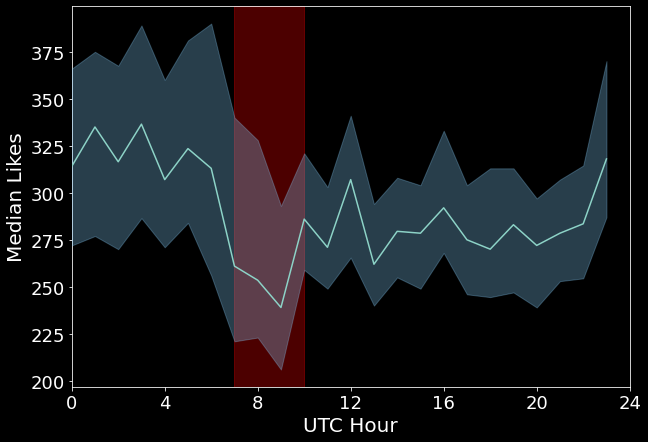

In [89]:
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(hour, med, zorder = 11)
ax.fill_between(hour, low, high, color='lightskyblue', alpha=.3, zorder = 10)
ax.axvspan(7, 10, alpha=0.3, color='red', zorder = 0)
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.set_xlabel('UTC Hour', fontsize = 20)
ax.set_ylabel('Median Likes', fontsize = 20)
ax.tick_params(axis="y", labelsize=18)
ax.tick_params(axis="x", labelsize=18)
ax.set_xlim(0,24);